In [1]:
####The foloowing code tries to recreate Fig. 2 of Turkeshi2025. Let us utilize Qiskit for now
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
import sys
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator
#np.set_printoptions(threshold=sys.maxsize)
import stim

In [2]:
##Firstly, we will write functions for creating 4^N Pauli strings for arbitrary N. We need a recursive nested function

Paulis = ['I', 'X', 'Y', 'Z']


N = 2
c = N
str1 = ''
PauliOps=[]

def PauliStrings(N,c,str1):
    if c == 1:
        for k in range(len(Paulis)):
            PauliOps.append(str1 + Paulis[k])
    else:
        for k in range(len(Paulis)):
            PauliStrings(N,c-1,str1+Paulis[k])
    

"""def PauliStrings2(N,c,str1):
    ops = []
    if c == 1:
        for i in range(len(Paulis)):
            ops.append(str1 + Paulis[i])
        return ops
    else:
        for i in range(len(Paulis)):
            PauliStrings2(N,c-1,str1+Paulis[i])"""
    

##Testing function
PauliStrings(N,c,str1)
print(len(PauliOps) == 4**N)
print(PauliOps)
#ops = PauliStrings2(N,c,str1)
#print(ops)

True
['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']


In [3]:
def PauliSpectrum(PauliOps, state):
    spec_vals = []
    for op in PauliOps:
        spec_vals.append(state.expectation_value(SparsePauliOp(op)))
    
    """sum = 0
    for val in spec_vals:
        sum += val**2
    print("Spectrum norm check:",sum/np.sqrt(len(spec_vals)))"""
    return spec_vals

def plot_histogram(data, N, num_bins=1000,a=-1,b=1):
    """
    Plots a histogram of values in `data` with `num_bins` bins.
    
    Parameters:
        data (array-like): Array of numbers between -1 and 1.
        num_bins (int): Number of bins for the histogram.
    """
    # Compute histogram
    #data = np.clip(data,a,b)
    counts, bin_edges = np.histogram(data, bins=np.linspace(a, b, num_bins + 1),density = True)

    #counts = counts*2/(np.sum(counts)*num_bins)

    # Compute bin midpoints (alternative: use bin_edges[:-1] for start values)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    d = 2**N
    D0 = 0 #d*(d-1)/2
    De = d**2 - D0
    b =  1/(d+1) #1/(0.5*d+1)

    th_vals = [(De - 1)*np.exp(-x**2/(2*b))/((d**2)*np.sqrt(2*np.pi*b)) for x in bin_midpoints]

    # Compute bin width
   # bin_width = bin_edges[1] - bin_edges[0]

    # Normalize to get probability density
    #pdf_values = counts / (len(data) * bin_width) #*(5*10**4)

    # Plot line plot instead of histogram
    plt.figure(figsize=(8, 5))
    plt.scatter(bin_midpoints, counts, marker='o', color='b', alpha=0.7)
    plt.plot(bin_midpoints,th_vals,'r--')
    
    # Labels and title
    plt.xlabel("Value")
    plt.ylabel("Probability Density")
    plt.title(f"Probability Density Function with {num_bins} Bins")
    # Log scale for y-axis
    plt.yscale("log")
    
    # Show grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()
    return 

In [4]:
##Let us define the H_TFIM and H_sb hamiltonian matrices for their mid-spectrum eigenstates.

def X(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'X'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Y(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Y'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def Z(i,N):  #i goes from 1 to N
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'Z'
    for k in range(N-i):
        str1 += 'I'
    return SparsePauliOp(str1)

def ZZ(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'ZZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)

def YZ(i,N): #i goes from 1 to N-1
    str1 = ''
    
    for k in range(i-1):
        str1 += 'I'
    str1 += 'YZ'
    for k in range(N-i-1):
        str1 += 'I'
    return SparsePauliOp(str1)


def H_tfim(N,g,J,h_list):
    op = 0
    for i in range(1,N):
        op += g*X(i,N) + h_list[i-1]*Z(i,N) + J*ZZ(i,N)
    op+=g*X(N,N) + h_list[N-1]*Z(N,N)
    return op

def H_sb(N,g,J,h_list):
    op = H_tfim(N,g,J,h_list)
    op += YZ(N-2,N) + YZ(N-1,N)
    return op




##Test for small number of qubits
print(X(1,3))
print(Y(2,3))
print(Z(3,3))
print(ZZ(1,3))
print(H_tfim(3,1,2,[1,1,1]))
print(H_sb(3,1,2,[1,1,1]))

print(SparsePauliOp.to_matrix(H_sb(3,1,2,[1,1,1]))[:,3])




SparsePauliOp(['XII'],
              coeffs=[1.+0.j])
SparsePauliOp(['IYI'],
              coeffs=[1.+0.j])
SparsePauliOp(['IIZ'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZZI'],
              coeffs=[1.+0.j])
SparsePauliOp(['XII', 'ZII', 'ZZI', 'IXI', 'IZI', 'IZZ', 'IIX', 'IIZ'],
              coeffs=[1.+0.j, 1.+0.j, 2.+0.j, 1.+0.j, 1.+0.j, 2.+0.j, 1.+0.j, 1.+0.j])
SparsePauliOp(['XII', 'ZII', 'ZZI', 'IXI', 'IZI', 'IZZ', 'IIX', 'IIZ', 'YZI', 'IYZ'],
              coeffs=[1.+0.j, 1.+0.j, 2.+0.j, 1.+0.j, 1.+0.j, 2.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j])
[ 0.+0.j  1.+1.j  1.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-1.j]


In [5]:
##We diagonalise the matrix and get mid-spectrum eigenstates

def mid_spec(op,a,b):
    mat = SparsePauliOp.to_matrix(op)
    eigvals,eigvecs = np.linalg.eigh(mat)

    midvecs = eigvecs[:,a:b]
    return midvecs

def plot_spectrum_midvecs(midvecs,PauliOps,a,b,num_bins = 100):
    d = midvecs.shape[0]
    N = int(np.log2(d))
    y = midvecs.shape[1]
    print("y:",y)
    counts = 0
    for i in range(y):
        print("i:",i)
        #print(midvecs[:,i])
        state = Statevector(midvecs[:,i])
        state = Statevector(np.ascontiguousarray(state.data))  #Parses the data as a contiguous array, can be removed if no memory allocation error pops up
        #print(state.data.flags)
        #print(state)
        
        #print(Statevector.is_valid(state))
        new_arr = PauliSpectrum(PauliOps,state)
        counts_new, bin_edges = np.histogram(new_arr, bins=np.linspace(a, b, num_bins + 1),density = True)  
        counts += counts_new
    counts_avg = counts/y  #average over histogram counts rather than spectrum
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    d = 2**N
    D0 = 0
    De = d**2 - D0
    b =  1/(d+1) #1/(d+1)

    th_vals = [(De - 1)*np.exp(-x**2/(2*b))/((d**2)*np.sqrt(2*np.pi*b)) for x in bin_midpoints]

    # Compute bin width
   # bin_width = bin_edges[1] - bin_edges[0]

    # Normalize to get probability density
    #pdf_values = counts / (len(data) * bin_width) #*(5*10**4)

    # Plot line plot instead of histogram
    plt.figure(figsize=(8, 5))
    plt.scatter(bin_midpoints, counts_avg, marker='o', color='b', alpha=0.7)
    plt.plot(bin_midpoints,th_vals,'r--')
    
    # Labels and title
    plt.xlabel("Value")
    plt.ylabel("Probability Density")
    plt.title(f"Probability Density Function with {num_bins} Bins")
    # Log scale for y-axis
    plt.yscale("log")
    
    # Show grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.show()
    return counts_avg

def hlist(N,J):
    h_list = [-J]
    for i in range(1,N):
        h_list.append((np.sqrt(5)+1)/4)
    return h_list

y: 205
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
i: 100
i: 101
i: 102
i: 103
i: 104
i: 105
i: 106
i: 107
i: 108
i: 109
i: 110
i: 111
i: 112
i: 113
i: 114
i: 115
i: 116
i: 117
i: 118
i: 119
i: 120
i: 121
i: 122
i: 123
i: 124
i: 125
i: 126
i: 127
i: 128
i: 129
i: 130
i: 131
i: 132
i: 133
i: 134
i: 135
i: 136
i: 137
i: 138
i: 139
i: 140
i: 141
i: 142
i: 143
i: 144
i: 145
i: 146
i: 147
i: 148
i: 149
i: 150
i: 151
i: 152
i: 153
i: 154
i: 155
i: 156
i: 1

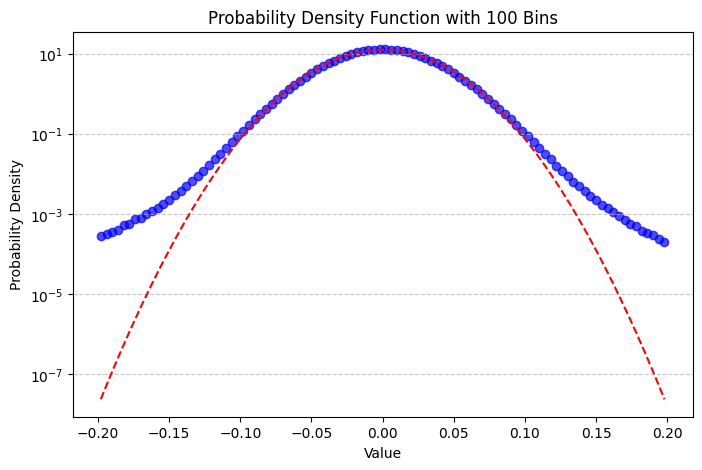

In [6]:
###Let us try and compute spectrum
N = 10
d = 2**N
J = 1
g = (np.sqrt(5) + 5)/8
h_list = hlist(N,J)
ran = np.min([int(d/10),(10**4)]) #can be a function of N only

PauliOps = []

PauliStrings(N,N,'')
#print(PauliOps)

midvecs_tri = mid_spec(H_tfim(N,g,J,h_list),int(d/2)-int(ran/2),int(d/2)+int(ran/2)+1) #incase range = 0
midvecs_ntri = mid_spec(H_sb(N,g,J,h_list),int(d/2)-ran,int(d/2)+ran+1)

#print("Midvecs_TRI:",midvecs_tri)
#print("Midvecs_non TRI:",midvecs_ntri)

fin_vals2 = plot_spectrum_midvecs(midvecs_ntri,PauliOps,-0.2,0.2)




In [7]:
#plot_histogram(fin_vals,10,100,-0.2,0.2)
np.savetxt("N=10_mfim_ntri_hist",fin_vals2)

In [115]:
##Let us run some checks
print(H_tfim(N,g,J,h_list))
print(midvecs_tri)

SparsePauliOp(['XIIIIIIIII', 'ZIIIIIIIII', 'ZZIIIIIIII', 'IXIIIIIIII', 'IZIIIIIIII', 'IZZIIIIIII', 'IIXIIIIIII', 'IIZIIIIIII', 'IIZZIIIIII', 'IIIXIIIIII', 'IIIZIIIIII', 'IIIZZIIIII', 'IIIIXIIIII', 'IIIIZIIIII', 'IIIIZZIIII', 'IIIIIXIIII', 'IIIIIZIIII', 'IIIIIZZIII', 'IIIIIIXIII', 'IIIIIIZIII', 'IIIIIIZZII', 'IIIIIIIXII', 'IIIIIIIZII', 'IIIIIIIZZI', 'IIIIIIIIXI', 'IIIIIIIIZI', 'IIIIIIIIZZ', 'IIIIIIIIIX', 'IIIIIIIIIZ'],
              coeffs=[ 0.9045085 +0.j, -1.        +0.j,  1.        +0.j,  0.9045085 +0.j,
  0.80901699+0.j,  1.        +0.j,  0.9045085 +0.j,  0.80901699+0.j,
  1.        +0.j,  0.9045085 +0.j,  0.80901699+0.j,  1.        +0.j,
  0.9045085 +0.j,  0.80901699+0.j,  1.        +0.j,  0.9045085 +0.j,
  0.80901699+0.j,  1.        +0.j,  0.9045085 +0.j,  0.80901699+0.j,
  1.        +0.j,  0.9045085 +0.j,  0.80901699+0.j,  1.        +0.j,
  0.9045085 +0.j,  0.80901699+0.j,  1.        +0.j,  0.9045085 +0.j,
  0.80901699+0.j])
[[ 1.72074123e-03+0.j  3.80732338e-04+0.j  2.33738458e-

In [113]:
##For figure 3, we need FSE for states



def FSE(q, d, spec):
    sum = 0
    if q == 0:
        return np.log2(d +1)
    elif q == 1:
        for i in range(1,len(spec)):
            if spec[i] == 0:
                sum+=0
            else:
                sum+=np.log2(np.abs(spec[i]))*(spec[i]**2)
        return -2*sum/(d-1)
    else:
        for i in range(1, len(spec)):
            sum += spec[i]**(2*q)
        sum/= (d-1)
        return np.log2(sum)/(1-q)
    
def HaarState(N):
    coeffs = []
    for i in range(2**N):
        z = np.random.randn() + 1j * np.random.randn()
        coeffs.append(z)
    coeffs = np.array(coeffs)
    hst = Statevector(coeffs)/np.linalg.norm(coeffs)
    return hst




In [ ]:
N_list = [10]
haar_vals = []
tri_vals = []

J = 1
g = (np.sqrt(5) + 5)/8

for q in [1,2,3,4,6]:
    list_haar = []
    list_tri = []
    for N in N_list:
        d = 2**N
        PauliOps = []

        PauliStrings(N,N,'')
        h_list = hlist(N,J)
        midvecs_tri = mid_spec(H_tfim(N,g,J,h_list),int(d/2)-ran,int(d/2)+ran+1) #incase range = 0
        print('Haar State:')
        haar_state = HaarState(N)
        haar_spec = PauliSpectrum(PauliOps,haar_state)
        print()
        print('TRI H')
        y = midvecs_tri.shape[1]
        FSE_val_tri = 0
        for i in range(y):
            
            state = Statevector(midvecs_tri[:,i])
            state = Statevector(np.ascontiguousarray(state.data))  #Parses the data as a contiguous array, can be removed if no memory allocation error pops up
            #print(state.data.flags)
            #print(state)
            
            #print(Statevector.is_valid(state))
            new_arr = PauliSpectrum(PauliOps,state)  
            FSE_val_tri += FSE(q,d,new_arr)
        FSE_val_tri/=y #average overFSE values rather than spectrum
        #sum = 0
        #for val in TRI_spec:
        #    sum += val**2
        #print(sum/d - 1)

        list_haar.append(FSE(q,d,haar_spec))
        list_tri.append(FSE_val_tri)
    
    haar_vals.append(list_haar)
    tri_vals.append(list_tri)
    print(haar_vals)
    print(tri_vals)

    plt.plot(N_list,list_haar,'--',label=f'q={q}')
    plt.plot(N_list,list_tri,'o',label = f'q = {q}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xlabel('N')
    plt.ylabel('FSE')

plt.show()



        

Haar State:

TRI H


KeyboardInterrupt: 